In [1]:
import os
import sys
from scipy import stats
import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

from string import ascii_lowercase as abc
abc = [*abc] + [f'{l}2' for l in abc]

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }

palette_educated = sb.color_palette('Oranges', 16)[:8]
palette_naive_test = 'Blues'
palette_naive_ot1 = 'Greens'
palette_human = sb.color_palette('Reds', 16)[8-1:]

color_greedy = 'silver'
color_active = 'tab:orange'
color_random = 'grey'
color_human = palette_tcrs['Human']

In [6]:
palette_pos = sb.color_palette('Set2', 9)#[2:]
palette_pos = dict(zip(range(1, 10), palette_pos))

In [7]:
palette_active = {'Active murine': palette_tcrs['Educated'],
                  'Random': color_random,
                  'Active human': palette_tcrs['Human'],}

## Load data

In [8]:
def load_experiment(filename):
    path_exp = f'../activation-prediction/results/active_learning/{filename}'
    with open(path_exp) as f:
        results_exp = json.load(f)
    return results_exp

In [9]:
results_within_mice = {
    'Active': load_experiment('within/SIINFEKL_FULL_act_avg_8.json'),
    'Random': load_experiment('within/SIINFEKL_FULL_rdm_8.json'),
}
results_within_human = {
    'Active': load_experiment('within/VPSVWRSSL_FULL_act_avg_8.json'),
    'Random': load_experiment('within/VPSVWRSSL_FULL_rdm_8.json'),
}

In [10]:
def get_mutation(apl, base):
    for i, (l1, l2) in enumerate(zip(apl, base)):
        if l1 != l2:
            return i+1, l1
    return '-', 'None'
    
def load_used_apls(filename):
    path_apls = f'../activation-prediction/results/active_learning/{filename}'
    base_epitope = 'SIINFEKL' if 'SIINFEKL' in filename else 'VPSVWRSSL'
    
    df_apls = pd.read_csv(path_apls, skiprows = 1,header = None)
    columns = ['seed', 'tcr'] + list(range(1, len(df_apls.columns)-1))
    df_apls.columns = columns
    df_apls[1] = df_apls[1].str[1:]
    df_apls[columns[-1]] = df_apls[columns[-1]].str[:-1]
    
    if 'within' in filename:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 81))]
    else:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 80))]
    
    for col in df_apls.columns:
        if col in ['seed', 'tcr']:
            continue
        df_apls[col] = df_apls[col].str.strip().str[1:-1]
        df_apls[f'pos_{col}'], df_apls[f'aa_{col}'] = zip(*df_apls[col].apply(lambda x: get_mutation(x, base_epitope)))        
    return df_apls

In [11]:
apls_within_mice = {
    'Active': load_used_apls('within/SIINFEKL_selectedAPLs_add_by_uncertainty_clf_avg.csv'),
    'Random': load_used_apls('within/SIINFEKL_selectedAPLs_add_by_random.csv'),
}
apls_within_human = {
    'Active': load_used_apls('within/VPSVWRSSL_selectedAPLs_add_by_uncertainty_clf_avg.csv'),
    'Random': load_used_apls('within/VPSVWRSSL_selectedAPLs_add_by_random.csv'),
}

## Plotting function

In [27]:
def plot_performance(data, metric, methods, ax=None, xticks=None, legend=False, active_color=None):
    dfs_results = []
    for method in methods:
        df = pd.DataFrame(data[method][metric])
        columns = ['tcr', 'educated', 'iteration', metric] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    
    #threshold = df_joint[(df_joint['method']=='Random') & (df_joint['iteration']==9)][metric].mean()
    threshold = 0.7 if metric == 'Spearman' else 0.85
    ax.axhline(threshold, linestyle='dashed', color='lightgray', linewidth=1)
    
    #x_thresh = df_joint[(df_joint['method']=='Active')].groupby('iteration')[metric].mean()
    #x_thresh = x_thresh[x_thresh>threshold].index[0]
    
    x_thresh = 2
    ax.axvline(x_thresh, linestyle='dashed', color='lightgray', linewidth=1)
    
    colors = {
        'Greedy_auc': color_greedy,
        'Greedy_spearman': color_greedy,
        'Active': color_active if active_color is None else active_color,
        'Random': color_random,
    }
    
    plot = sb.lineplot(data=df_joint, x='iteration', y=metric, hue='method', ax=ax, palette=colors)


    sb.despine(bottom=False, left=False)

    plot.set_xlabel('Training Samples', labelpad=1)
    plot.set_ylabel(metric.upper() if len(metric)<4 else metric, labelpad=1)
    

    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], label=name, color=color)
                          for name, color in palette_active.items()]
        ax.legend(handles=legend_elements, title=None, bbox_to_anchor=(1.35, 1.2), 
                  loc="upper center", ncol=3, frameon=False)
    else:
        ax.get_legend().remove()
    plot.set_xticks(list(range(len(xticks))))
    plot.set_xticklabels(xticks, size='small')
    
    ax.tick_params(axis='both', which='major', pad=-2)
    
    ax.grid(False)
    sb.despine(ax=ax)

In [13]:
def plot_used_apls(df_apl, group='pos', groups=None, title='', ax=None, xticks=None):
    df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith(group)]]
    df_tmp = df_tmp.apply(lambda x: x.value_counts())
    df_tmp = df_tmp.fillna(0)
    df_tmp = df_tmp.transpose()
    
    if groups is not None:
        df_tmp['groups'] = groups
        df_tmp = df_tmp.groupby('groups').sum()
        df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
    
    df_tmp.plot(kind='bar', stacked=True, color=palette_pos, ax=ax)
    ax.set_title(title, pad=0)
    ax.set_xlabel('Iteration', labelpad=1)
    ax.set_ylabel('Fraction of Selection', labelpad=1)
    ax.set_xticklabels([el//8 for el in xticks], rotation=0)
    
    ax.tick_params(axis='both', which='major', pad=-2)
    ax.get_legend().remove()
    
    ax.grid(False)
    sb.despine(ax=ax)
    return df_tmp

In [14]:
def plot_used_apls(df_apl, group='pos', groups=None, title='', ax=None, xticks=None):
    df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith(group)]]
    df_tmp = df_tmp.apply(lambda x: x.value_counts())
    df_tmp = df_tmp.fillna(0)
    df_tmp = df_tmp.transpose()
    
    if groups is not None:
        df_tmp['groups'] = groups
        df_tmp = df_tmp.groupby('groups').sum()
        df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
    
    df_tmp.plot(kind='barh', stacked=True, color=palette_pos, ax=ax)
    ax.set_title(title, pad=0)
    ax.set_ylabel('Iteration', labelpad=1)
    ax.set_xlabel('Fraction of selected batch', labelpad=1)
    ax.set_yticklabels([int(el.get_text())+1 for el in ax.get_yticklabels()], rotation=0)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', which='major', pad=-2)
    ax.get_legend().remove()
    
    ax.grid(False)
    sb.despine(ax=ax)
    return df_tmp

In [15]:
def plot_legend(ax):
    legend_elements = [mpl.patches.Patch(facecolor=color, edgecolor=color, label=f'P{name}')
                      for name, color in palette_pos.items()]
    ax.legend(handles=legend_elements, #ncol=9, 
              loc='center right', bbox_to_anchor=(1.225, 0.5), frameon=True,
              title='Epitope\nPosition')

In [16]:
def plot_icon(ax, name='human', color=palette_tcrs['Human'], xmin=0., xmax=1.):
    img = plt.imread(f'../figures/{name}.png')
    color_human = mpl.colors.to_rgba(color)
    for i, c in enumerate(color_human):
        img[img[:,:,i]!=1, i] = c
        
    xdiff = xmax - xmin
    scale = 1.2
    ax.imshow(img, extent=[6.5, 6.5+3*scale, xmin-xdiff/15 *scale, xmin+(1-1/15 * scale)*xdiff*0.3*scale], 
              alpha=0.5, aspect='auto')

## Figure 6

In [17]:
dfs_results = []
for metric in ['Spearman', 'auc']:
    for method in ['Random', 'Active']:
        df = pd.DataFrame(results_within_human[method][metric])
        columns = ['tcr', 'educated', 'iteration', 'value'] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        df['metric'] = metric
        dfs_results.append(df)
res_human = pd.concat(dfs_results)
res_human = res_human.drop(columns=['educated'])

In [18]:
dfs_results = []
for metric in ['Spearman', 'auc']:
    for method in ['Random', 'Active']:
        df = pd.DataFrame(results_within_mice[method][metric])
        columns = ['tcr', 'educated', 'iteration', 'value'] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        df['metric'] = metric
        dfs_results.append(df)
res_mice = pd.concat(dfs_results)
res_mice = res_mice.drop(columns=['educated'])

In [19]:
# human minimal value
min_hm_sp = res_human[res_human['metric']=='Spearman'].groupby(['iteration', 'method'])['value'].mean().min()
max_hm_sp = res_human[res_human['metric']=='Spearman'].groupby(['iteration', 'method'])['value'].mean().max()
min_hm_ac = res_human[res_human['metric']=='auc'].groupby(['iteration', 'method'])['value'].mean().min()
max_hm_ac = res_human[res_human['metric']=='auc'].groupby(['iteration', 'method'])['value'].mean().max()

# Mice minimal value
min_mc_sp = res_mice[res_mice['metric']=='Spearman'].groupby(['iteration', 'method'])['value'].mean().min()
max_mc_sp = res_mice[res_mice['metric']=='Spearman'].groupby(['iteration', 'method'])['value'].mean().max()
min_mc_ac = res_mice[res_mice['metric']=='auc'].groupby(['iteration', 'method'])['value'].mean().min()
max_mc_ac = res_mice[res_mice['metric']=='auc'].groupby(['iteration', 'method'])['value'].mean().max()

<ipython-input-28-31657e1eeb90>:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


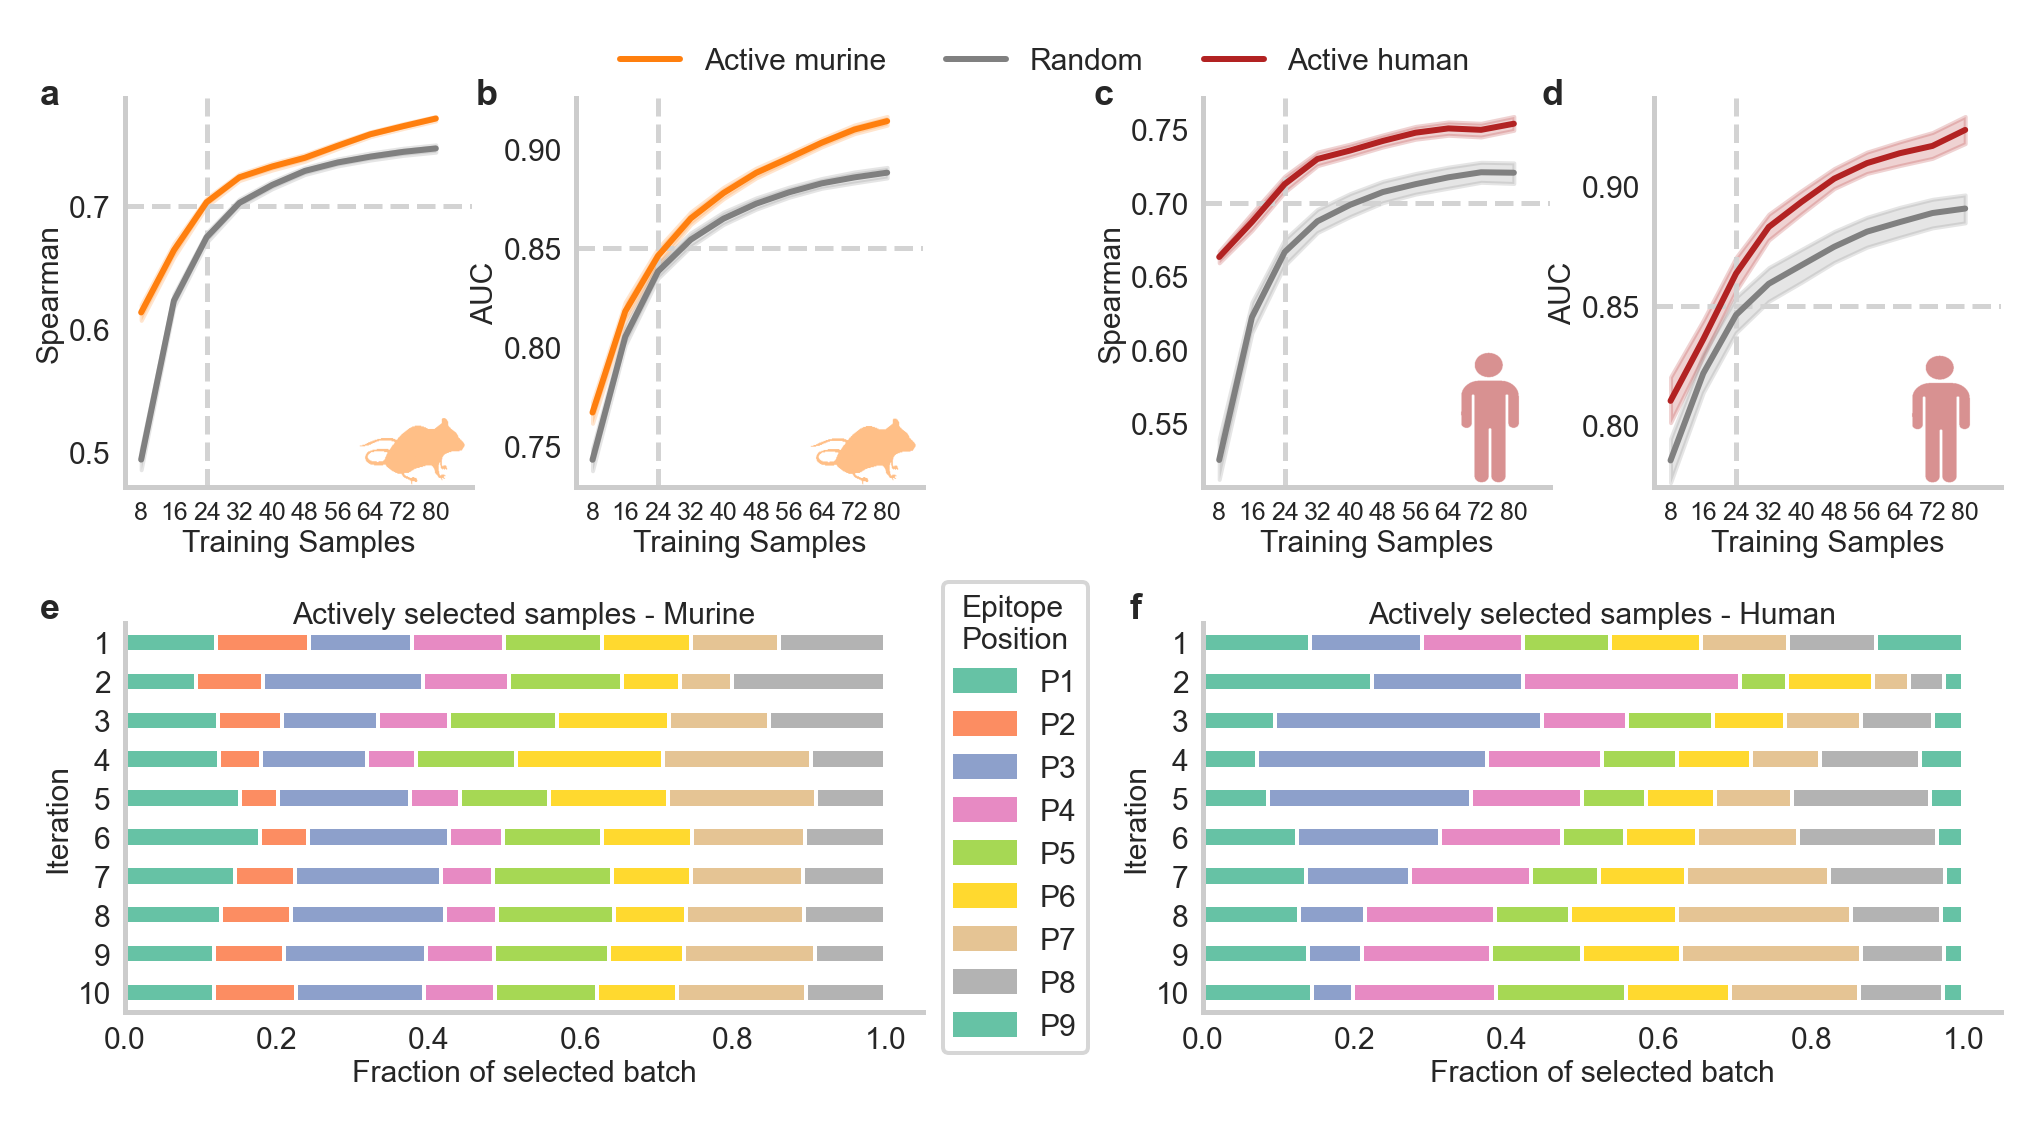

In [28]:
# auc within mice     spr across mice 
#      APLs               APLs
# active - greedy     active - greedy
set_font_size(6)
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.5), dpi=DPI)
gridspecs = {}
axes = {}

"""gridspecs['gs_full'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    hspace=0.35,
    height_ratios=[3, 3],
)

gridspecs['gs1-4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][0],
    nrows=1,
    ncols=4,
    wspace=0.35,
    width_ratios=[1, 1, 1, 1],
)
gridspecs['gs5-6'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    hspace=0.45,
    width_ratios=[1, 1],
)"""

gridspecs['gs_full'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    wspace=0.35,
    width_ratios=[1, 1],
)

gridspecs['gs125'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    hspace=0.35,
)
gridspecs['gs12'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs125'][0],
    nrows=1,
    ncols=2,
    wspace=0.30,
    width_ratios=[1, 1],
)
gridspecs['gs346'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    hspace=0.35,
)
gridspecs['gs34'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs346'][0],
    nrows=1,
    ncols=2,
    wspace=0.30,
    width_ratios=[1, 1],
)

axes['ax_1'] = fig.add_subplot(gridspecs['gs12'][0])
axes['ax_2'] = fig.add_subplot(gridspecs['gs12'][1])
axes['ax_3'] = fig.add_subplot(gridspecs['gs34'][0])
axes['ax_4'] = fig.add_subplot(gridspecs['gs34'][1])

axes['ax_5'] = fig.add_subplot(gridspecs['gs125'][1])
axes['ax_6'] = fig.add_subplot(gridspecs['gs346'][1])


plot_icon(axes['ax_1'], name='mouse', color=palette_tcrs['Educated'], xmin=min_mc_sp, xmax=max_mc_sp)
plot_icon(axes['ax_2'], name='mouse', color=palette_tcrs['Educated'], xmin=min_mc_ac, xmax=max_mc_ac)
plot_icon(axes['ax_3'], xmin=min_hm_sp, xmax=max_hm_sp)
plot_icon(axes['ax_4'], xmin=min_hm_ac, xmax=max_hm_ac)

groups = [0] + [i//8 for i in range(79)]
xticks = [8+8*i for i in range(10)]
plot_performance(results_within_mice, 'Spearman', ['Active', 'Random'], ax=axes['ax_1'], xticks=xticks)
plot_performance(results_within_mice, 'auc', ['Active', 'Random'], ax=axes['ax_2'], xticks=xticks, 
                 legend=True)

plot_used_apls(apls_within_mice['Active'], groups=groups,ax=axes['ax_5'], xticks=xticks, 
               title='Actively selected samples - Murine')


plot_performance(results_within_human, 'Spearman', ['Active', 'Random'], ax=axes['ax_3'], xticks=xticks,
                active_color=color_human)
plot_performance(results_within_human, 'auc', ['Active', 'Random'], ax=axes['ax_4'], xticks=xticks,
                active_color=color_human)
plot_used_apls(apls_within_human['Active'], groups=groups, ax=axes['ax_6'], xticks=xticks, 
               title='Actively selected samples - Human')


plot_legend(ax=axes['ax_5'])

fig.text(0.09, 0.875, 'a', size='large', weight='bold')
fig.text(0.27, 0.875, 'b', size='large', weight='bold')
fig.text(0.525, 0.875, 'c', size='large', weight='bold')
fig.text(0.71, 0.875, 'd', size='large', weight='bold')
fig.text(0.09, 0.45, 'e', size='large', weight='bold')
fig.text(0.54, 0.45, 'f', size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_fig6_active.pdf', dpi=DPI, bbox_inches='tight')

## Separated by TCR

set_font_size(12)
n_cols = 4
n_rows = 6
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols * 3, n_rows * 3))


for i, tcr in enumerate(['R21', 'R23', 'R24', 'R25', 'R26', 'R28']):
    for j, mode in enumerate([results_within_human, results_across_human]):
        res_methods = {}
        for method, method_dict in mode.items():
            res_metric = {}
            for metric, metric_dict in method_dict.items():
                res = [el for el in metric_dict if el[0]==tcr]
                res_metric[metric] = res
            res_methods[method] = res_metric
        
        if mode == results_within_human:
            xticks = [9+8*i for i in range(10)]
        else:
            xticks = [8+8*i for i in range(10)]
        #print(res_methods)
        plot_performance(res_methods, 'auc', ['Active', 'Random'], ax=axes[i][j*2], xticks=xticks, 
                         active_color=color_human)
        axes[i][j*2].set_title(tcr)
        plot_performance(res_methods, 'Spearman', ['Active', 'Random'], ax=axes[i][j*2+1], xticks=xticks, 
                         active_color=color_human)
        axes[i][j*2+1].set_title(tcr)
        
plt.tight_layout()
plt.show()

tcrs = list(set([el[0] for el in results_within_mice['Active']['MAE']]))

n_cols = 4
n_rows = len(tcrs)
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols * 3, n_rows * 3))

for i, tcr in enumerate(tcrs):
    for j, mode in enumerate([results_within_mice, results_across_mice]):
        res_methods = {}
        for method, method_dict in mode.items():
            res_metric = {}
            for metric, metric_dict in method_dict.items():
                res = [el for el in metric_dict if el[0]==tcr]
                res_metric[metric] = res
            res_methods[method] = res_metric
        
        if mode == results_within_human:
            xticks = [9+8*i for i in range(10)]
        else:
            xticks = [8+8*i for i in range(10)]
        plot_performance(res_methods, 'auc', ['Active', 'Random'], ax=axes[i][j*2], xticks=xticks)
        axes[i][j*2].set_title(tcr)
        plot_performance(res_methods, 'Spearman', ['Active', 'Random'], ax=axes[i][j*2+1], xticks=xticks)
        axes[i][j*2+1].set_title(tcr)
        
plt.tight_layout()
plt.show()

## Stats

In [21]:
for metric in ['auc', 'Spearman']:
    print(f'-{metric}')
    for i in range(10):
        df_act = res_mice.query(f'metric=="{metric}" & method=="Active" & iteration=={i}')
        df_rdm = res_mice.query(f'metric=="{metric}" & method=="Random" & iteration=={i}')
        mean_act = df_act['value'].mean()
        mean_rdm = df_rdm['value'].mean()
        t_test = stats.ttest_ind(df_act[~df_act['value'].isna()]['value'].values, 
                                 df_rdm[~df_rdm['value'].isna()]['value'].values)
        print(f'It {i}: Active={mean_act:.3f} - Random={mean_rdm:.3f} - Diff={mean_act-mean_rdm:.3f} - pval={t_test[1]}')

-auc
It 0: Active=0.767 - Random=0.743 - Diff=0.024 - pval=2.6522708331220135e-09
It 1: Active=0.818 - Random=0.805 - Diff=0.013 - pval=9.138913082379177e-05
It 2: Active=0.846 - Random=0.838 - Diff=0.008 - pval=0.00393334776363545
It 3: Active=0.865 - Random=0.854 - Diff=0.011 - pval=6.205605750723881e-06
It 4: Active=0.878 - Random=0.865 - Diff=0.013 - pval=7.557886345869137e-10
It 5: Active=0.888 - Random=0.872 - Diff=0.016 - pval=6.341356973942025e-16
It 6: Active=0.895 - Random=0.878 - Diff=0.017 - pval=1.745203019301887e-21
It 7: Active=0.903 - Random=0.882 - Diff=0.021 - pval=4.513344211322382e-32
It 8: Active=0.910 - Random=0.885 - Diff=0.024 - pval=4.356185274717516e-43
It 9: Active=0.914 - Random=0.888 - Diff=0.026 - pval=8.504814626508887e-49
-Spearman
It 0: Active=0.614 - Random=0.494 - Diff=0.120 - pval=6.925833359486026e-101
It 1: Active=0.664 - Random=0.623 - Diff=0.041 - pval=1.674619820930491e-24
It 2: Active=0.703 - Random=0.675 - Diff=0.029 - pval=3.1318366559442428e

In [22]:
for metric in ['auc', 'Spearman']:
    print(f'-{metric}')
    for i in range(10):
        df_act = res_human.query(f'metric=="{metric}" & method=="Active" & iteration=={i}')
        df_rdm = res_human.query(f'metric=="{metric}" & method=="Random" & iteration=={i}')
        mean_act = df_act['value'].mean()
        mean_rdm = df_rdm['value'].mean()
        t_test = stats.ttest_ind(df_act[~df_act['value'].isna()]['value'].values, 
                                 df_rdm[~df_rdm['value'].isna()]['value'].values)
        print(f'It {i}: Active={mean_act:.3f} - Random={mean_rdm:.3f} - Diff={mean_act-mean_rdm:.3f} - pval={t_test[1]}')

-auc
It 0: Active=0.810 - Random=0.785 - Diff=0.025 - pval=0.00019255565248000496
It 1: Active=0.836 - Random=0.822 - Diff=0.014 - pval=0.015456722619436751
It 2: Active=0.864 - Random=0.846 - Diff=0.017 - pval=0.0009545515496676699
It 3: Active=0.883 - Random=0.859 - Diff=0.024 - pval=1.2977926177190558e-07
It 4: Active=0.894 - Random=0.867 - Diff=0.026 - pval=8.864747336635791e-10
It 5: Active=0.903 - Random=0.875 - Diff=0.028 - pval=2.148757313678911e-12
It 6: Active=0.910 - Random=0.881 - Diff=0.029 - pval=7.968938382847983e-13
It 7: Active=0.914 - Random=0.885 - Diff=0.029 - pval=5.611776560641012e-13
It 8: Active=0.917 - Random=0.889 - Diff=0.028 - pval=6.549757680139323e-12
It 9: Active=0.924 - Random=0.891 - Diff=0.033 - pval=1.8213866927212215e-14
-Spearman
It 0: Active=0.663 - Random=0.525 - Diff=0.138 - pval=1.9662654300313317e-69
It 1: Active=0.687 - Random=0.622 - Diff=0.065 - pval=1.337682285359429e-24
It 2: Active=0.713 - Random=0.667 - Diff=0.046 - pval=2.25340777935471

In [23]:
df_apl = apls_within_mice['Active']
df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith('pos')]]
df_tmp = df_tmp.apply(lambda x: x.value_counts())
df_tmp = df_tmp.fillna(0)
df_tmp = df_tmp.transpose()

if groups is not None:
    df_tmp['groups'] = groups
    df_tmp = df_tmp.groupby('groups').sum()
    df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
df_apls_mice = df_tmp
df_apls_mice

,1,2,3,4,5,6,7,8
groups,,,,,,,,
0,0.120667,0.122000,0.135185,0.121333,0.128963,0.116074,0.116593,0.139185
1,0.093917,0.088500,0.209750,0.113083,0.149083,0.076417,0.068417,0.200833
2,0.122583,0.084583,0.125500,0.094083,0.142417,0.146417,0.132000,0.152417
3,0.124417,0.054500,0.139333,0.064417,0.131667,0.193917,0.194667,0.097083
4,0.151417,0.050583,0.172667,0.066667,0.117000,0.156250,0.194250,0.091167
5,0.178000,0.063167,0.185333,0.070500,0.131167,0.117833,0.148583,0.105417
6,0.144667,0.079583,0.191417,0.068333,0.156500,0.104333,0.147000,0.108167
7,0.126917,0.092500,0.202083,0.068250,0.153500,0.094500,0.156083,0.106167
8,0.117583,0.092250,0.186917,0.088333,0.151583,0.098917,0.172750,0.091667


In [24]:
df_apl = apls_within_human['Active']
df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith('pos')]]
df_tmp = df_tmp.apply(lambda x: x.value_counts())
df_tmp = df_tmp.fillna(0)
df_tmp = df_tmp.transpose()

if groups is not None:
    df_tmp['groups'] = groups
    df_tmp = df_tmp.groupby('groups').sum()
    df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
df_apls_human = df_tmp
df_apls_human

,1,3,4,5,6,7,8,9
groups,,,,,,,,
0,0.141296,0.147407,0.132593,0.114630,0.119630,0.114630,0.115741,0.114074
1,0.222292,0.198542,0.286250,0.061042,0.113750,0.046667,0.046250,0.025208
2,0.094583,0.351042,0.112917,0.112292,0.095417,0.098958,0.094583,0.040208
3,0.070833,0.303333,0.151458,0.097708,0.097708,0.090833,0.131250,0.056875
4,0.086458,0.265833,0.146042,0.085208,0.089583,0.101250,0.182292,0.043333
5,0.123750,0.188333,0.160208,0.083333,0.094167,0.133333,0.182500,0.034375
6,0.136042,0.136250,0.159792,0.089167,0.114792,0.187500,0.152708,0.023750
7,0.126458,0.087500,0.170833,0.098542,0.140625,0.228125,0.118125,0.029792
8,0.137917,0.071458,0.169792,0.119792,0.130000,0.236875,0.108750,0.025417
